In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 8s - loss: 0.1159

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 556ms/step - loss: 0.0921
Average validation loss: 0.7271679043769836
4/4 [==============================] - 5s 567ms/step - loss: 0.0921 - val_loss: 0.7272
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 550ms/step - loss: 0.0641 - val_loss: 0.7272
Average validation loss: 0.6635968685150146
4/4 [==============================] - 7s 557ms/step - loss: 0.0641 - val_loss: 0.6954
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 9s 557ms/step - loss: 0.0485 - val_loss: 0.6954
Average validation loss: 0.5564278364181519
4/4 [==============================] - 9s 570ms/step - loss: 0.0485 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 804ms/step - loss: 4.8356e-05
Average validation loss: 0.22689342498779297
8/8 [==============================] - 7s 818ms/step - loss: 4.8356e-05 - val_loss: 0.2269
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 793ms/step - loss: 4.7178e-05 - val_loss: 0.2269
Average validation loss: 0.06256980262696743
8/8 [==============================] - 13s 807ms/step - loss: 4.7178e-05 - val_loss: 0.1447
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 19s 716ms/step - loss: 4.6682e-05 - val_loss: 0.1447
Average validation loss: 0.02415288332849741
8/8 [==============================] - 19s 728ms/ste

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 683ms/step - loss: 1.3396e-04
Average validation loss: 0.06371456519948045
12/12 [==============================] - 8s 694ms/step - loss: 1.3396e-04 - val_loss: 0.0637
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 748ms/step - loss: 1.3269e-04 - val_loss: 0.0637
Average validation loss: 0.0279432083092009
12/12 [==============================] - 17s 759ms/step - loss: 1.3269e-04 - val_loss: 0.0458
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 703ms/step - loss: 1.2900e-04 - val_loss: 0.0458
Average validation loss: 0.043785708820602544
12/12 [==============================] - 2

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 698ms/step - loss: 7.0892e-05
Average validation loss: 0.05943789360389928
16/16 [==============================] - 11s 709ms/step - loss: 7.0892e-05 - val_loss: 0.0594
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 731ms/step - loss: 6.8179e-05 - val_loss: 0.0594
Average validation loss: 0.021017983905039728
16/16 [==============================] - 23s 742ms/step - loss: 6.8179e-05 - val_loss: 0.0402
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 719ms/step - loss: 6.6794e-05 - val_loss: 0.0402
Average validation loss: 0.027797582559287548
16/16 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 709ms/step - loss: 3.6741e-05
Average validation loss: 0.06961662275716662
20/20 [==============================] - 14s 719ms/step - loss: 3.6741e-05 - val_loss: 0.0696
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 738ms/step - loss: 3.5194e-05 - val_loss: 0.0696
Average validation loss: 0.026527602691203356
20/20 [==============================] - 29s 747ms/step - loss: 3.5194e-05 - val_loss: 0.0481
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 713ms/step - loss: 3.4981e-05 - val_loss: 0.0481
Average validation loss: 0.03578924186294898
20/20 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 16s 678ms/step - loss: 7.3354e-05
Average validation loss: 0.03881715393314759
24/24 [==============================] - 17s 688ms/step - loss: 7.3354e-05 - val_loss: 0.0388
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 33s 685ms/step - loss: 5.5245e-05 - val_loss: 0.0388
Average validation loss: 0.02926315739750862
24/24 [==============================] - 33s 696ms/step - loss: 5.5245e-05 - val_loss: 0.0340
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 50s 685ms/step - loss: 4.6523e-05 - val_loss: 0.0340
Average validation loss: 0.030187750856081646
24/24 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 703ms/step - loss: 1.0274e-04
Average validation loss: 0.11238689422607422
40/40 [==============================] - 29s 713ms/step - loss: 1.0274e-04 - val_loss: 0.1124
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 705ms/step - loss: 8.9850e-05 - val_loss: 0.1124
Average validation loss: 0.056486109644174574
40/40 [==============================] - 57s 716ms/step - loss: 8.9850e-05 - val_loss: 0.0844
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 85s 706ms/step - loss: 8.1597e-05 - val_loss: 0.0844
Average validation loss: 0.03548580799251795
40/40 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 693ms/step - loss: 5.8265e-05
Average validation loss: 0.03556621145980898
48/48 [==============================] - 34s 703ms/step - loss: 5.8265e-05 - val_loss: 0.0356
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 67s 701ms/step - loss: 4.1956e-05 - val_loss: 0.0356
Average validation loss: 0.025297481270778615
48/48 [==============================] - 68s 711ms/step - loss: 4.1956e-05 - val_loss: 0.0304
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 102s 704ms/step - loss: 3.5130e-05 - val_loss: 0.0304
Average validation loss: 0.0231808169822519
48/48 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 695ms/step - loss: 7.1745e-05
Average validation loss: 0.023626742651686072
56/56 [==============================] - 40s 705ms/step - loss: 7.1745e-05 - val_loss: 0.0236
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 697ms/step - loss: 4.9867e-05 - val_loss: 0.0236
Average validation loss: 0.027725508785806596
56/56 [==============================] - 79s 707ms/step - loss: 4.9867e-05 - val_loss: 0.0257
Epoch 3/10
56/56 [==============================] - 118s 699ms/step - loss: 4.0019e-05 - val_loss: 0.0257
Average validation loss: 0.026849749556276947
56/56 [==============================] - 119s 709ms/step - loss: 4.0019e-05 - val_loss: 0.0261
Epoch 4/10
56/56 [==============================] - 158s 694ms/step - loss: 3.2418e-05 - val_loss: 0.0261
Average val

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 702ms/step - loss: 3.7542e-05
Average validation loss: 0.018856533017242327
64/64 [==============================] - 46s 712ms/step - loss: 3.7542e-05 - val_loss: 0.0189
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 90s 690ms/step - loss: 2.3985e-05 - val_loss: 0.0189
Average validation loss: 0.014940163935534656
64/64 [==============================] - 90s 700ms/step - loss: 2.3985e-05 - val_loss: 0.0169
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 135s 694ms/step - loss: 1.9907e-05 - val_loss: 0.0169
Average validation loss: 0.013644111706526019
64/64 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 697ms/step - loss: 4.5878e-05
Average validation loss: 0.016491262837209635
72/72 [==============================] - 51s 707ms/step - loss: 4.5878e-05 - val_loss: 0.0165
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 690ms/step - loss: 2.9917e-05 - val_loss: 0.0165
Average validation loss: 0.016546038574435644
72/72 [==============================] - 101s 700ms/step - loss: 2.9917e-05 - val_loss: 0.0165
Epoch 3/10
72/72 [==============================] - 151s 690ms/step - loss: 2.3841e-05 - val_loss: 0.0165
Average validation loss: 0.01582014371847941
72/72 [==============================] - 152s 700ms/step - loss: 2.3841e-05 - val_loss: 0.0163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_061

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 700ms/step - loss: 3.5274e-05
Average validation loss: 0.027022015163674952
80/80 [==============================] - 57s 710ms/step - loss: 3.5274e-05 - val_loss: 0.0270
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 113s 703ms/step - loss: 2.3493e-05 - val_loss: 0.0270
Average validation loss: 0.017133766319602728
80/80 [==============================] - 114s 713ms/step - loss: 2.3493e-05 - val_loss: 0.0221
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 171s 716ms/step - loss: 1.8298e-05 - val_loss: 0.0221
Average validation loss: 0.017209101095795633
80/80 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 703ms/step - loss: 6.0045e-05
Average validation loss: 0.03276262906729244
96/96 [==============================] - 69s 714ms/step - loss: 6.0045e-05 - val_loss: 0.0328
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 699ms/step - loss: 3.9518e-05 - val_loss: 0.0328
Average validation loss: 0.03428501331169779
96/96 [==============================] - 137s 709ms/step - loss: 3.9518e-05 - val_loss: 0.0335
Epoch 3/10
96/96 [==============================] - 204s 702ms/step - loss: 2.9680e-05 - val_loss: 0.0335
Average validation loss: 0.02592026837131319
96/96 [==============================] - 205s 712ms/step - loss: 2.9680e-05 - val_loss: 0.0310
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 704ms/step - loss: 3.6711e-05
Average validation loss: 0.0174733697824801
120/120 [==============================] - 86s 714ms/step - loss: 3.6711e-05 - val_loss: 0.0175
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 169s 698ms/step - loss: 2.4789e-05 - val_loss: 0.0175
Average validation loss: 0.014973987871780992
120/120 [==============================] - 171s 708ms/step - loss: 2.4789e-05 - val_loss: 0.0162
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 255s 701ms/step - loss: 1.9661e-05 - val_loss: 0.0162
Average validation loss: 0.011469223893557985
120/120 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 700ms/step - loss: 3.2979e-05
Average validation loss: 0.022126199751963012
144/144 [==============================] - 102s 710ms/step - loss: 3.2979e-05 - val_loss: 0.0221
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 705ms/step - loss: 2.4302e-05 - val_loss: 0.0221
Average validation loss: 0.015214807599679463
144/144 [==============================] - 205s 715ms/step - loss: 2.4302e-05 - val_loss: 0.0187
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 307s 705ms/step - loss: 1.9106e-05 - val_loss: 0.0187
Average validation loss: 0.01989305651255159
144/144 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 700ms/step - loss: 1.3173e-05
Average validation loss: 0.01920920734264655
160/160 [==============================] - 114s 710ms/step - loss: 1.3173e-05 - val_loss: 0.0192
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 225s 695ms/step - loss: 1.2452e-05 - val_loss: 0.0192
Average validation loss: 0.017201068190479417
160/160 [==============================] - 226s 704ms/step - loss: 1.2452e-05 - val_loss: 0.0182
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 338s 697ms/step - loss: 1.0175e-05 - val_loss: 0.0182
Average validation loss: 0.01849549252747238
160/160 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 142s 709ms/step - loss: 4.7381e-05
Average validation loss: 0.02869499921333045
200/200 [==============================] - 144s 719ms/step - loss: 4.7381e-05 - val_loss: 0.0287
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 286s 709ms/step - loss: 3.4445e-05 - val_loss: 0.0287
Average validation loss: 0.022351689741481096
200/200 [==============================] - 288s 719ms/step - loss: 3.4445e-05 - val_loss: 0.0255
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 431s 717ms/step - loss: 2.6773e-05 - val_loss: 0.0255
Average validation loss: 0.013868776173330844
200/200 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:52 - loss: 1.6404e-05

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 716ms/step - loss: 2.7571e-05
Average validation loss: 0.016255883574679806
240/240 [==============================] - 174s 726ms/step - loss: 2.7571e-05 - val_loss: 0.0163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 347s 721ms/step - loss: 1.8234e-05 - val_loss: 0.0163
Average validation loss: 0.01494070127676726
240/240 [==============================] - 350s 731ms/step - loss: 1.8234e-05 - val_loss: 0.0156
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 520s 711ms/step - loss: 1.4135e-05 - val_loss: 0.0156
Average validation loss: 0.013687922276828128
240/240 [============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1014329096296342, 0.06558328973867972, 0.07171684097740921, 0.04144247293384978, 0.030134772987337785, 0.021661548320553267, 0.03190107486583293, 0.02367964885498319, 0.021797644592339304, 0.018886741631431506, 0.01881609778983855, 0.019836224858605422, 0.01862417422317473, 0.017629683235846946, 0.016309296108496105, 0.014436856131364037, 0.015222327497998046, 0.012850052788975217]
std_val_losses =  [0.17917130781369572, 0.05419478885328394, 0.045505231163749535, 0.01672238747438431, 0.010727667947270937, 0.009950557847643485, 0.01516803365958329, 0.005548296695859898, 0.00611743943750067, 0.013395890498303127, 0.01235034071954936, 0.0098068583045511, 0.0075760935149440725, 0.00804978761507569, 0.004022853795331837, 0.00647751087997029, 0.005866524141286061, 0.003955769062354292]


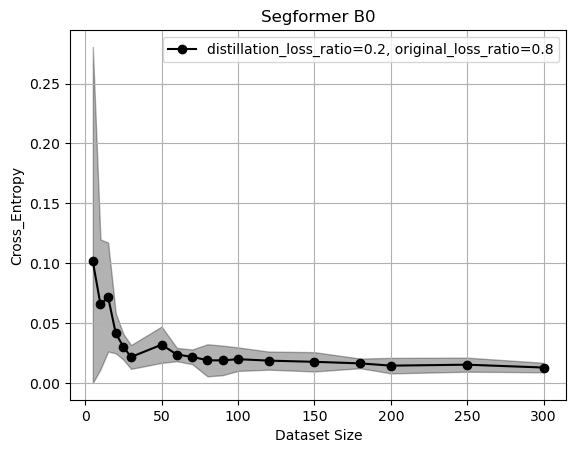

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()